# Running Grover's Algorithm on a Quantum Computer

Local Simulator

## Dependencies

In [ ]:
!pip install qiskit-ibm-runtime 'qiskit[visualization]' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = FakeManilaV2()
backend.name

'fake_manila'

In [ ]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

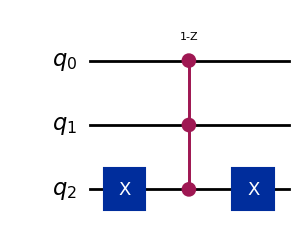

In [ ]:
marked_states = ["011"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

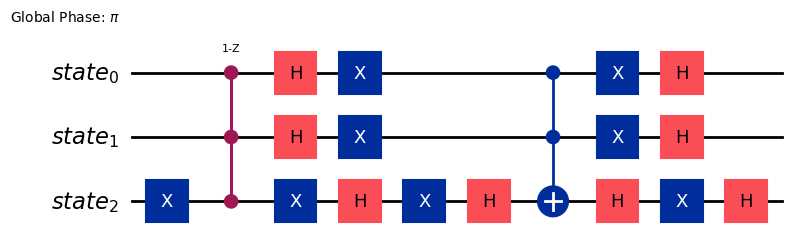

In [ ]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [ ]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
print(optimal_num_iterations)

2


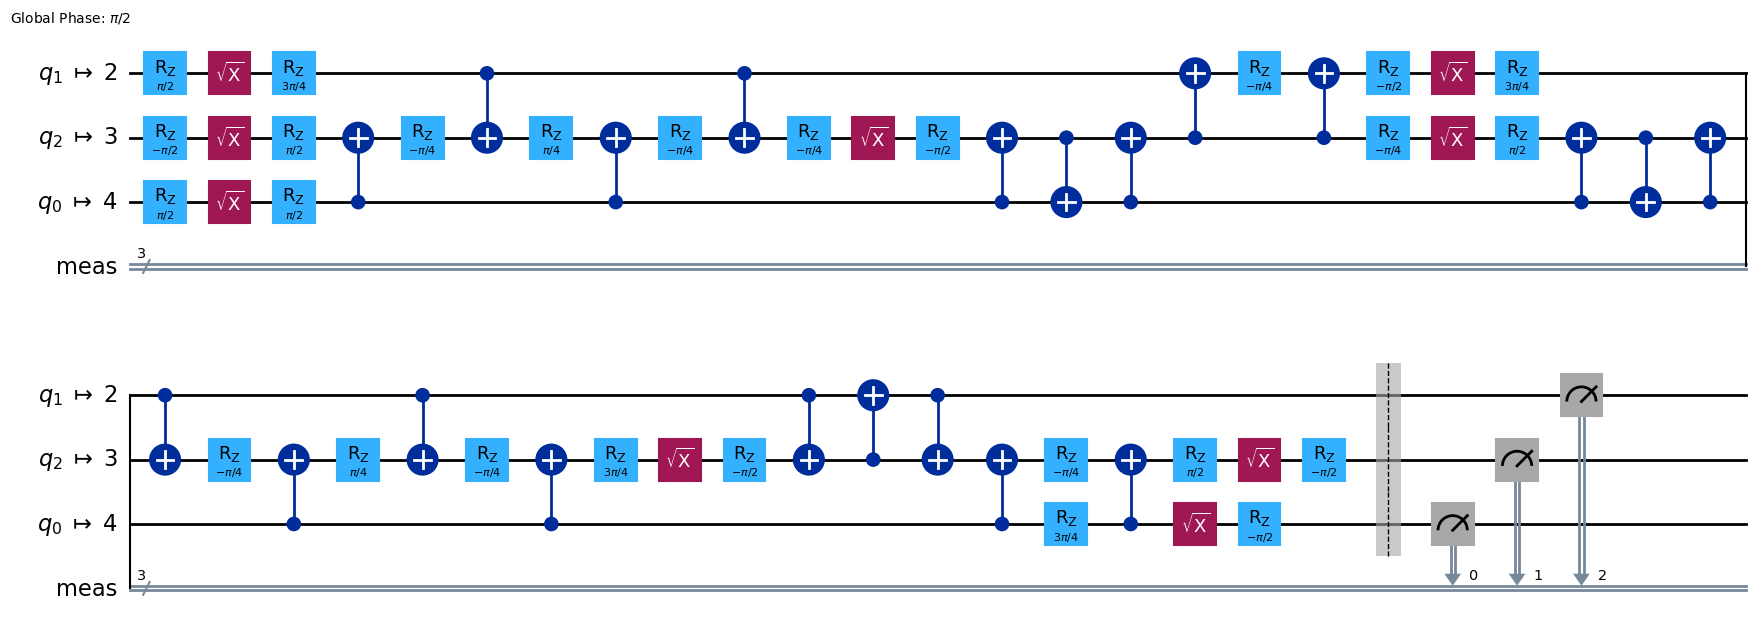

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(1), inplace=True)
qc.measure_all(add_bits=True)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 10_000
# result = sampler.run([circuit_isa]).result()


In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

results = []
for i in range(1, optimal_num_iterations+1):
  qc = QuantumCircuit(grover_op.num_qubits)
  qc.h(range(grover_op.num_qubits))
  qc.compose(grover_op.power(i), inplace=True)
  qc.measure_all(add_bits=True)

  target = backend.target
  pm = generate_preset_pass_manager(target=target, optimization_level=3)

  circuit_isa = pm.run(qc)
  circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

  sampler = Sampler(mode=backend)
  sampler.options.default_shots = 10_000
  result = sampler.run([circuit_isa]).result()
  results.append(result)


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:467: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:467: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


In [ ]:
sampler = Sampler(mode=backend) # We may not need this code block
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()
print(len(dist))

8


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:467: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


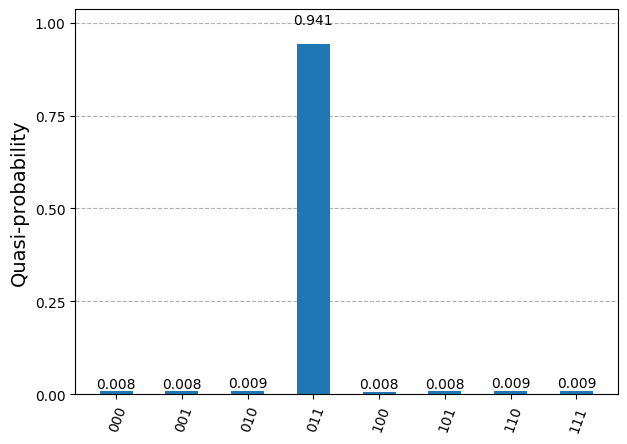

In [ ]:
plot_distribution(dist) # TODO: Plot two graphs of both results instead of dist from only first result

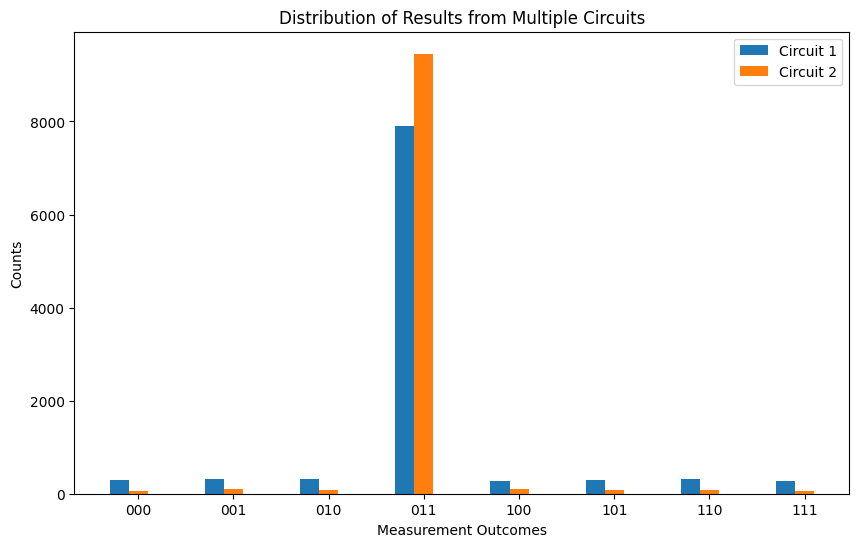

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

distributions = [result[0].data.meas.get_counts() for result in results]
plt.figure(figsize=(10, 6))

for i, dist in enumerate(distributions):
    keys = sorted(dist.keys())
    counts = [dist.get(key, 0) for key in keys]
    plt.bar(np.arange(len(keys)) + i * 0.2, counts, width=0.2, label=f'Circuit {i+1}', align='center')

plt.xticks(np.arange(len(keys)) + 0.2, keys)
plt.xlabel('Measurement Outcomes')
plt.ylabel('Counts')
plt.title('Distribution of Results from Multiple Circuits')
plt.legend()
plt.show()


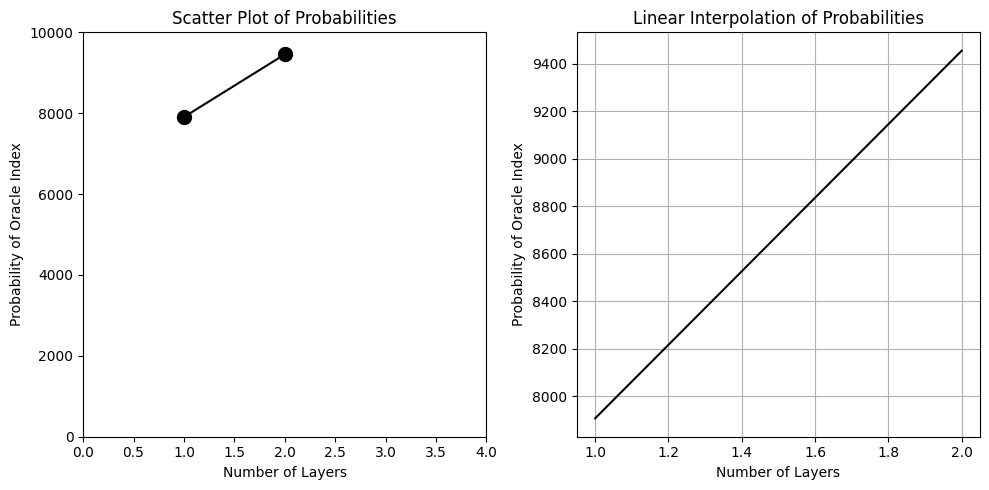

In [ ]:
index_prob = []
for dist in distributions:
  index_prob.append(dist[marked_states[0]])

t = np.arange(1, len(index_prob)+1, 1) # (start, stop, step)
y = index_prob

plt.figure(figsize=(10, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.plot(t, y, color='black', marker='.',markersize=20)
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Number of Layers')
plt.ylabel('Probability of Oracle Index')
plt.xlim(0,len(index_prob)+2 )
plt.ylim(0, 10000)

# Linear interpolation
plt.subplot(1, 2, 2)
plt.plot(t, y, label='Data', color='black')
plt.title('Linear Interpolation of Probabilities')
plt.xlabel('Number of Layers')
plt.ylabel('Probability of Oracle Index')
plt.grid()

plt.tight_layout()
plt.show()

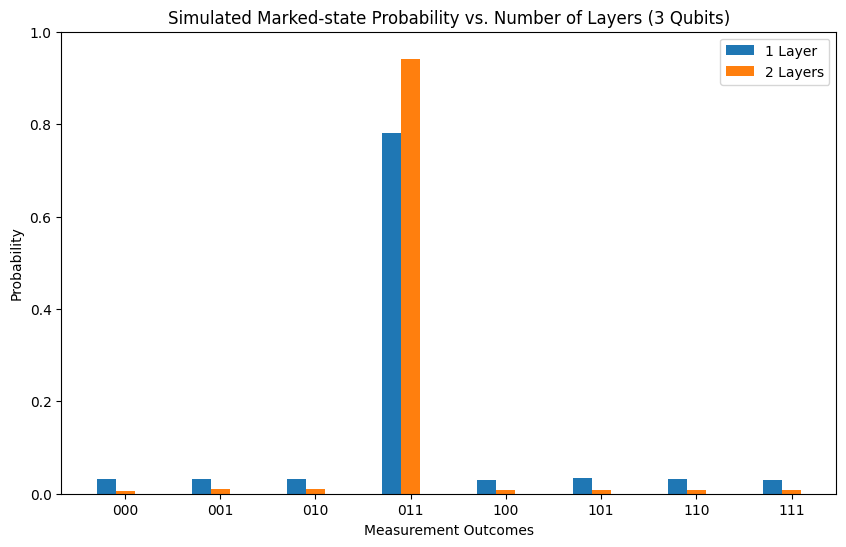

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

distributions = [result[0].data.meas.get_counts() for result in results]

plt.figure(figsize=(10, 6))

for i, dist in enumerate(distributions):
    keys = sorted(dist.keys())
    counts = [dist.get(key, 0) for key in keys]
    probabilities = [dist.get(key, 0)/sum(counts) for key in keys]


    bars = plt.bar(np.arange(len(keys)) + i * 0.2, probabilities, width=0.2, label=f'{i+1} Layers' if (i+1)>1 else f'{i+1} Layer', align='center')
plt.xticks(np.arange(len(keys)) + 0.2, keys)
plt.xlabel('Measurement Outcomes')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.title('Simulated Marked-state Probability vs. Number of Layers (3 Qubits)')
plt.legend()
plt.show()